In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins.hparams import api as hp #used for hyperparameter tuning
import datetime

import io
import itertools

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Downloading and preprocessing the data

In [4]:
BUFFER_SIZE = 70_000
BATCH_SIZE = 128
NUM_EPOCH =20

In [5]:
mnist_dataset, mnist_info = tfds.load(name="mnist", with_info=True, as_supervised=True)

split data into train and test sets

In [6]:
# Extracting the train and test datasets
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

create a function to scale the value[0,255] to value[0,1]

In [7]:
def scale(image, label):
    image =tf.cast(image, tf.float32) #to avoid problems with data types
    image /= 255.

    return image, label #need to include label in here because the map function below

apply above function to both mnist_train and mnist_test

In [8]:
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

obtain the number training/validation samples

In [9]:
num_validation_samples =0.1 * mnist_info.splits["train"].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

same with test set

In [10]:
num_test_samples = mnist_info.splits["test"].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

Shuffle the dataset

In [11]:
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE) #in this case MNIST dataset is relatively small we can shuffle in one go 
                                                                           #but for larger datasets we can set the BUFFER_SIZE to shuffle in batches
                                                                            

split our training set

In [12]:
train_data = train_and_validation_data.skip(num_validation_samples) #return everything except the first 10%
validation_data = train_and_validation_data.take(num_validation_samples) #return the first 10%

batch our dataset to improve performance

In [13]:
train_data = train_data.batch(batch_size=BATCH_SIZE) #larger batch size improve performance especially on GPU 
                                                     #but smaller batch size may provide better test accuracy and it's desirable to set it as power of 2
#validation and test sets don't need to be batched as we don't backward propagate on them however the model expects it to be batched to get the proper dimensions
validation_data = validation_data.batch(num_validation_samples)
test_data = test_data.batch(num_test_samples)

Extract data from validation and convert them into numpy array

In [14]:
for images, labels in validation_data:
    images_val = images.numpy()
    labels_val = labels.numpy()

# Defining hyperparameters

In [18]:
HP_FILTER_SIZE = hp.HParam('filter_size', hp.Discrete([3, 5, 7])) #kernel size 3x3 5x5 7x7
HP_OPTIMIZER = hp.HParam("optimizer", hp.Discrete(["adam", "sgd"])) #optimizer adam and stochastic gradient descent
                                                                     #adam is much sophisticated than sgd so we expect it will
                                                                     #outperform sgd
METRIC_ACCURACY = "accuracy"

with tf.summary.create_file_writer("logs/hparam_tuning").as_default():
    hp.hparams_config(
        hparams=[HP_FILTER_SIZE, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name="Accuracy")]
    )

## Cerating functions for training our model and for logging purposes

In [19]:
def train_test_model(hparams):
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, hparams[HP_FILTER_SIZE], activation="relu", input_shape=(28 , 28, 1)), #replaced kernel size with hparams
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Conv2D(50, hparams[HP_FILTER_SIZE], activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),  #this layer's purpose is to turn a multi-dimensional tensor into a a one-dimensional vector so we can perform classification in the next layer
    tf.keras.layers.Dense(10) #it's impossible to produce a numerically stable loss function for all models so we won't define activation function here
])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
    model.compile(optimizer=hparams[HP_OPTIMIZER], loss=loss_fn, metrics=["accuracy"]) #replaced optimizer with hparams
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", #monitor validation loss during training
    mode = "auto",
    min_delta = 0,
    patience = 2,
    verbose = 0,
    restore_best_weights = True #this is set so that if validation loss increases for two epoch programme will stop
)
    model.fit(
    train_data,
    epochs = NUM_EPOCH,
    callbacks = [early_stopping],  
    validation_data = validation_data,
    verbose = 1 
)
    _, accuracy = model.evaluate(test_data)
    return accuracy

In [20]:
def run(log_dir, hparams):

    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams) #record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

# Training the model with different hyperparameters

In [21]:
session_num = 0

for filter_size in HP_FILTER_SIZE.domain.values: #nested for loops to go through all combination of hyperparameters
    for optimizer in HP_OPTIMIZER.domain.values:

        hparams = {                            #current values for hyperparameter
            HP_FILTER_SIZE:filter_size,
            HP_OPTIMIZER: optimizer
        }
        run_name = "run-%d" % session_num
        print("--- Starting trial: %s" %run_name)     #print out useful info for user
        print({h.name: hparams[h] for h in hparams})
        run("logs/hparam_tuning/" + run_name, hparams) #call function to train the network and log results

        session_num += 1

--- Starting trial: run-0
{'filter_size': 3, 'optimizer': 'adam'}
Epoch 1/20
422/422 [==============================] - 8s 5ms/step - loss: 0.2986 - accuracy: 0.9162 - val_loss: 0.0935 - val_accuracy: 0.9712
Epoch 2/20
422/422 [==============================] - 2s 4ms/step - loss: 0.0796 - accuracy: 0.9755 - val_loss: 0.0583 - val_accuracy: 0.9805
Epoch 3/20
422/422 [==============================] - 2s 4ms/step - loss: 0.0582 - accuracy: 0.9824 - val_loss: 0.0430 - val_accuracy: 0.9873
Epoch 4/20
422/422 [==============================] - 2s 4ms/step - loss: 0.0470 - accuracy: 0.9855 - val_loss: 0.0396 - val_accuracy: 0.9872
Epoch 5/20
422/422 [==============================] - 2s 3ms/step - loss: 0.0412 - accuracy: 0.9875 - val_loss: 0.0447 - val_accuracy: 0.9865
Epoch 6/20
422/422 [==============================] - 2s 3ms/step - loss: 0.0354 - accuracy: 0.9890 - val_loss: 0.0286 - val_accuracy: 0.9917
Epoch 7/20
422/422 [==============================] - 2s 3ms/step - loss: 0.0308 -

## Creating the model and training it

In [118]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation="relu", input_shape=(28 , 28, 1)), #first layer with 50 kernel and size of 5 activation function of choice is relu
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), #second layer, pool_size(2,2) is the default but we specified it for clarity
    tf.keras.layers.Conv2D(50, 3, activation="relu"), #input_shape removed as it's only needed in the first layer and smaller kernel size to accommandate smaller images
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),  #this layer's purpose is to turn a multi-dimensional tensor into a a one-dimensional vector so we can perform classification in the next layer
    tf.keras.layers.Dense(10) #it's impossible to produce a numerically stable loss function for all models so we won't define activation function here
])

In [119]:
model.summary(line_length=75) #this is to check if our model initialised correctly 

Model: "sequential_5"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d_10 (Conv2D)              (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d_10 (MaxPooling2D)  (None, 12, 12, 50)           0           
                                                                           
 conv2d_11 (Conv2D)              (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_11 (MaxPooling2D)  (None, 5, 5, 50)             0           
                                                                           
 flatten_5 (Flatten)             (None, 1250)                  0           
                                                                           
 dense_5 (Dense)                 (None, 10)                    125

loss function

In [120]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) #from_logits = True tells tf to use softmax activation

In [121]:
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"]) # this combines our model with loss function


Logging functions for Confusion matrix in order to evaluate our model's performance

In [122]:
log_dir = "Logs\\fit\\" + "run-2"

Codes below are provided by Tensorflow documentation on Confusion Matrix in Tensorboard

In [123]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

In [124]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside the notebook.
    plt.close(figure)
    
    buf.seek(0)
    
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [125]:
# Define a file writer variable for logging purposes
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(images_val)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)
    
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

Early stopping to prevent overfitting

In [126]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", #monitor validation loss during training
    mode = "auto",
    min_delta = 0,
    patience = 2,
    verbose = 0,
    restore_best_weights = True #this is set so that if validation loss increases for two epoch programme will stop
)

Setting up Tensorboard

In [127]:
#log_dir = "log\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [128]:
model.fit(
    train_data,
    epochs = NUM_EPOCH,
    callbacks = [tensorboard_callback, cm_callback, early_stopping],  #it's possible to use more than one callbacks hence the []
                                                         #note early_stopping should be the last element in the list
                                                         #otherwise model may bug out
    validation_data = validation_data,
    verbose = 1 #2 means info will only be printed at end of each epoch
                #verbose = 2 seems to introduce an error in tensorboard
                #changed to 1 for this reason
)

Epoch 1/20
422/422 [==============================] - 11s 24ms/step - loss: 0.2552 - accuracy: 0.9273 - val_loss: 0.0788 - val_accuracy: 0.9767
Epoch 2/20
422/422 [==============================] - 11s 25ms/step - loss: 0.0692 - accuracy: 0.9792 - val_loss: 0.0482 - val_accuracy: 0.9865
Epoch 3/20
422/422 [==============================] - 3s 5ms/step - loss: 0.0505 - accuracy: 0.9841 - val_loss: 0.0409 - val_accuracy: 0.9877
Epoch 4/20
422/422 [==============================] - 4s 9ms/step - loss: 0.0412 - accuracy: 0.9877 - val_loss: 0.0271 - val_accuracy: 0.9920
Epoch 5/20
422/422 [==============================] - 3s 5ms/step - loss: 0.0348 - accuracy: 0.9899 - val_loss: 0.0292 - val_accuracy: 0.9892
Epoch 6/20
422/422 [==============================] - 3s 5ms/step - loss: 0.0309 - accuracy: 0.9902 - val_loss: 0.0222 - val_accuracy: 0.9932
Epoch 7/20
422/422 [==============================] - 3s 5ms/step - loss: 0.0269 - accuracy: 0.9921 - val_loss: 0.0241 - val_accuracy: 0.9928
Ep

As you can see the training stopped early due to val_loss increase for 2 Epochs

# Testing our model

In [129]:
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 4s 4s/step - loss: 0.0289 - accuracy: 0.9904


In [130]:
print("Test loss: {0: .4f}. Test accuracy: {1: .2f}%".format(test_loss, test_accuracy*100))

Test loss:  0.0289. Test accuracy:  99.04%


Over 99% Accuracy!

## Plotting images and the results

In [131]:
import matplotlib.pyplot as plt
import numpy as np

In [132]:
#split the test data into 2 arrays, containing the images and the corresponding labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

#reshape the image into 28x28 form, suitable for matplotlib (original dimension 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

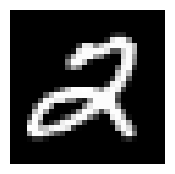

Label: 2


In [133]:
# The image to be displayed and tested
i = 1


# Plot the image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Print the correct label for the image
print("Label: {}".format(labels_test[i-1]))

1/1 [==============================] - 0s 28ms/step


<BarContainer object of 10 artists>

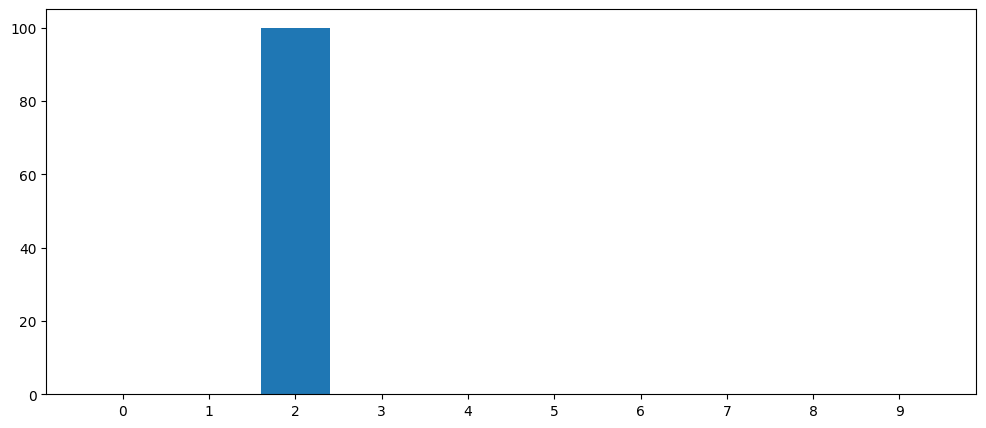

In [134]:
# Obtain the model's predictions (logits)
predictions = model.predict(images_test[i-1:i])

# Convert those predictions into probabilities (recall that we incorporated the softmaxt activation into the loss function)
probabilities = tf.nn.softmax(predictions).numpy()
# Convert the probabilities into percentages
probabilities = probabilities*100


# Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])

Above graph shows our model have almost 100% confidence in the number 2

# Visualising in Tensorboard

In [135]:
%load_ext tensorboard
%tensorboard --logdir "logs/fit"


Reusing TensorBoard on port 6006 (pid 29096), started 1 day, 0:04:25 ago. (Use '!kill 29096' to kill it.)

If tensorboard doesn't load try the following commands in cmd:

In [136]:
# taskkill /im tensorboard.exe /f
# del /q %TMP%\.tensorboard-info\*

#this will end existing tensorboard process and clean any temp data associated

Confusion matrix and visualising it with Tensorboarb